In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# API Hogwash
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

#Extract the zipfile that is just downloaded. This may take a while.
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as z:
  z.extractall(".")

kaggle.json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

chest_xray		  ConfusionMatrix.png  sample_data
chest-xray-pneumonia.zip  kaggle.json


In [ ]:
mainDIR = os.listdir('chest_xray')
print(mainDIR)

['train', '__MACOSX', 'chest_xray', 'val', 'test']


In [ ]:
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

#labelling: n=normal, p=pneumonia

train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'

In [ ]:
# print(f"Train - Normal:{len(os.listdir(train_n))}")
# print(f"Train - Pneumonia:{len(os.listdir(train_p))}")
datasets = ["train", "test", "val"]
labels = ["_n", "_p"]

sizeDict = {}

for dataset in datasets:
  print(f"{dataset} size")
  for label in labels:
    # print(f"\t{dataset+label}:{len(os.listdir(locals()[dataset+label]))}")
    sizeDict[dataset+label] = len(os.listdir(locals()[dataset+label]))

print(sizeDict)

train size
test size
val size
{'train_n': 1341, 'train_p': 3875, 'test_n': 234, 'test_p': 390, 'val_n': 8, 'val_p': 8}


Text(0.5, 1.0, 'Imbalance Between Normal and Pneumonia Images')

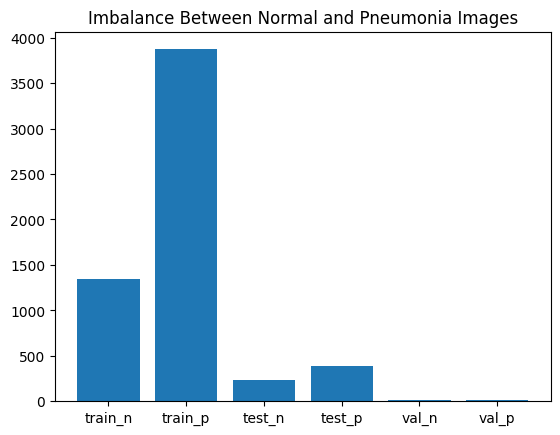

In [ ]:
import matplotlib.pyplot as plt

plt.bar(sizeDict.keys(), sizeDict.values())
plt.title(label="Imbalance Between Normal and Pneumonia Images")

In [ ]:
os.listdir(train_folder)

['NORMAL', 'PNEUMONIA']

1341
normal picture title:  NORMAL2-IM-0526-0001.jpeg
pneumonia picture title: person1088_bacteria_3028.jpeg


Text(0.5, 1.0, 'Pneumonia')

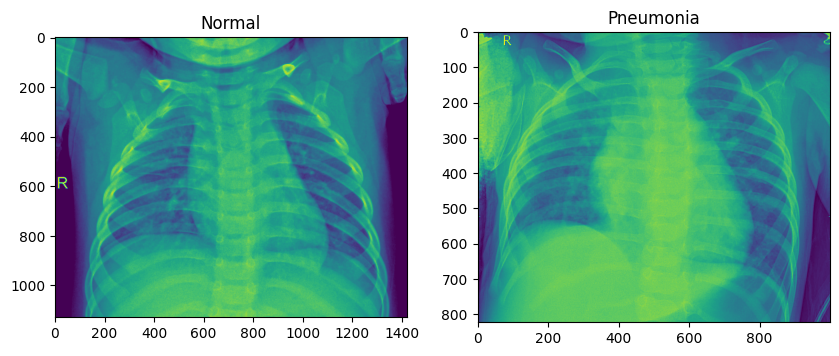

In [ ]:
print(len(os.listdir(train_n)))

#normal
n_pic = os.listdir(train_n)[0]
n_pic_address = train_n+n_pic
print('normal picture title: ',n_pic)

#Pneumonia
p_pic =  os.listdir(train_p)[0]
p_pic_address = train_p+p_pic
print('pneumonia picture title:', p_pic)

# Load the images
n_load = Image.open(n_pic_address)
p_load = Image.open(p_pic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(n_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(p_load)
a2.set_title('Pneumonia')

In [ ]:
#denseNet reference. https://www.kaggle.com/georgiisirotenko/pytorch-x-ray-transfer-learning-densenet


In [ ]:
torch.manual_seed(RANDOM_SEED)

# Define the transformer
train_transformer = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                  transforms.RandomRotation(10),
                                  transforms.RandomEqualize(),
                                  transforms.Resize(IMG_RESIZE),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  # transforms.Normalize(mean=[IMG_CHANNEL_MEAN, IMG_CHANNEL_MEAN, IMG_CHANNEL_MEAN], std=[IMG_CHANNEL_STD, IMG_CHANNEL_STD, IMG_CHANNEL_STD])
                                  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ])
test_transformer = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                  transforms.Resize(IMG_RESIZE),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  ])


# Read the training and validation datasets from their respective folders
train_imgs = datasets.ImageFolder(root=train_folder, transform=test_transformer)
# valid_imgs = datasets.ImageFolder(root=valid_folder, transform=transformer) # Only 16 images (8/8)


# So a stratified subsampling of the training images to get our training and validation sets
# https://linuxtut.com/en/c6023453e00bfead9e9f/
train_indices, valid_indices = train_test_split(list(range(len(train_imgs.targets))), test_size=0.1, stratify=train_imgs.targets)
train_dataset = torch.utils.data.Subset(train_imgs, train_indices)
valid_dataset = torch.utils.data.Subset(train_imgs, valid_indices)

# Compute the class weights in both sets (should be similar after train_test_split)
train_weights = torch.FloatTensor(make_weights_for_balanced_classes(train_dataset.dataset.imgs, len(train_dataset.dataset.classes)))
valid_weights = torch.FloatTensor(make_weights_for_balanced_classes(valid_dataset.dataset.imgs, len(valid_dataset.dataset.classes)))

# Create the training and validation DataLoaders, with a WeightedRandomSampler to account for class imbalance
# Shout out to Janine for saying to use .dataset attribute
# (https://discuss.pytorch.org/t/how-to-iterate-subset-after-random-split-typeerror-dataloader-object-is-not-subscriptable/73933/3)
train_loader = DataLoader(dataset=train_dataset.dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=WeightedRandomSampler(train_weights, len(train_weights), generator=torch.Generator().manual_seed(RANDOM_SEED)))
valid_loader = DataLoader(dataset=valid_dataset.dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=WeightedRandomSampler(valid_weights, len(valid_weights), generator=torch.Generator().manual_seed(RANDOM_SEED)))


##Old
# import torchvision.transforms as transform
# transformer = transform.Compose([
#     transform.Resize(256),
#     transform.CenterCrop(224),
#     transform.ToTensor(),
#     transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# transform.RandomHorizontalFlip(),transform.RandomRotation(10),transform.RandomGrayscale(),transform.RandomAffine(translate=(0.05,0.05), degrees=0),

In [ ]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(train_folder, transform=transformer)

print(dataset.classes)
print(len(dataset))

['NORMAL', 'PNEUMONIA']
5216


In [ ]:
# from sklearn.model_selection import train_test_split

# random_seed = 0
# torch.manual_seed(random_seed);

# train_batch_size = 50
# val_batch_size = 50

# train_set, val_set = train_test_split(dataset, test_size=0.3, random_state=random_seed)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


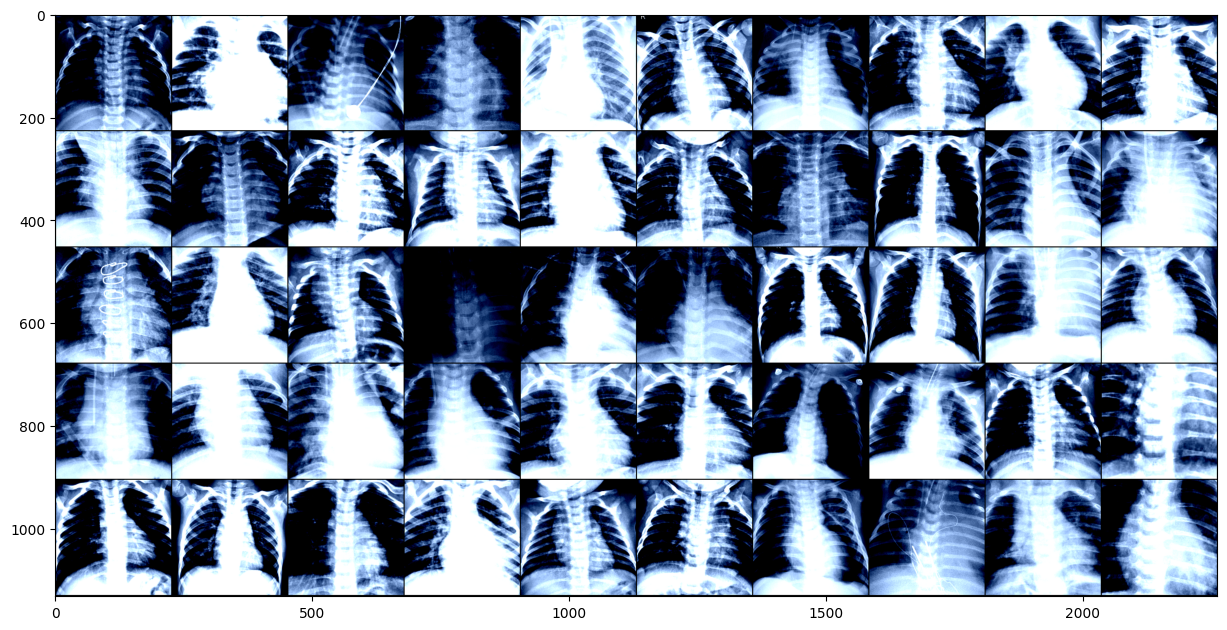

In [ ]:
from torchvision.utils import make_grid

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(make_grid(images[:50], nrow=10).permute(1,2,0))
        break
        
show_batch(train_loader)

#Model Generation

In [ ]:
# Helper Functions

def train(train_loader, model, criterion, optimizer, device):
  '''
  Function for the training step of the training loop
  '''
  model.train()
  running_loss = 0

  for X, y_true in train_loader:

    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    # #SVM with weight regularization penalty
    # output = model(X).squeeze()
    # # weight = model.weight.squeeze()
    # loss = torch.mean(torch.clamp(1 - y_true * output, min=0))
    # # loss += 0.001 * (weight.t() @ weight) / 2.0 #regularize the weight (=0.001)

    # Forward Pass - Get predictions for the batch using the current weights
    y_hat = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward Pass - Adjust weights based on the loss
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  '''
  Function for the validation step of the training loop
  '''

  model.eval()
  running_loss = 0

  for X, y_true in valid_loader:

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward Pass
    y_hat = model(X)

    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss


def get_accuracy(model, data_loader, device):
  '''
  Function for computing the accuracy of the predictions over the entire data_loader
  '''
  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in data_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

    #   def accuracy(outputs, labels):
    # _, preds = torch.max(outputs, dim=1) 
    # return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

  return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
  '''
  Function for plotting training and validation losses
  '''

  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss') 
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title="Loss over epochs", 
         xlabel='Epoch',
         ylabel='Loss') 
  ax.legend()
  fig.show()
  
  # change the plot style to default
  plt.style.use('default')

def plot_accuracies(train_accs, valid_accs):
  '''
  Function for plotting training and validation losses
  '''

  plt.style.use('seaborn')

  train_accs = np.array(train_accs)
  valid_accs = np.array(valid_accs)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_accs, color='blue', label='Training Accuracy')
  ax.plot(valid_accs, color='red', label='Validation Accuracy')
  ax.set(title="Classification Accuracy Over Epochs", 
         xlabel='Epoch',
         ylabel='Accuracy') 
  ax.legend()
  fig.show()
  
  # change the plot style to default
  plt.style.use('default')


In [ ]:
# Main Training Loop
# SVM: https://github.com/kazuto1011/svm-pytorch/blob/master/main.py

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  '''
  Function defining the entire training loop
  '''

  # Set objects for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  # Training Loop
  for epoch in range(epochs):

    # Training Step
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation Step
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every - 1):

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      train_accs.append(train_acc)
      valid_accs.append(valid_acc)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch}\t'
            f'Train loss: {train_loss:.4f}\t'
            f'Valid loss: {valid_loss:.4f}\t'
            f'Train accuracy: {100 * train_acc:.2f}\t'
            f'Valid accuracy: {100 * valid_acc:.2f}')
    
  plot_losses(train_losses, valid_losses)
  plot_accuracies(train_accs, valid_accs)

  return model, optimizer, (train_losses, valid_losses)

In [ ]:
RANDOM_SEED = 0
LEARNING_RATE = 0.001
BATCH_SIZE = 50
N_EPOCHS = 30
N_CLASSES = 2
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = torchvision.models.densenet121(pretrained=True)

In [ ]:
# Transfer Learning Reference: https://www.kaggle.com/xanthate/transfer-learning-pytorch
import torch.nn as nn
from collections import OrderedDict

#Freeze the upper layer

for parameter in model.parameters():
  parameter.requires_grad = False

in_features = model.classifier.in_features
# dense161.classifier = nn.Linear(in_features, 2)
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(in_features, 2)])


# dense161.classifier = nn.Sequential(*features) 
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(in_features,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl4', nn.Linear(32,2)),
    ('out', nn.LogSoftmax(dim=1)),
]))


In [ ]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
model.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

15:08:47 --- Epoch: 0	Train loss: 0.3073	Valid loss: 0.1314	Train accuracy: 94.44	Valid accuracy: 95.08
15:10:02 --- Epoch: 1	Train loss: 0.1632	Valid loss: 0.2154	Train accuracy: 90.08	Valid accuracy: 90.35
15:11:18 --- Epoch: 2	Train loss: 0.1991	Valid loss: 0.1122	Train accuracy: 95.29	Valid accuracy: 95.85
15:12:34 --- Epoch: 3	Train loss: 0.1336	Valid loss: 0.0905	Train accuracy: 96.36	Valid accuracy: 96.61
15:13:49 --- Epoch: 4	Train loss: 0.1626	Valid loss: 0.0911	Train accuracy: 96.30	Valid accuracy: 96.61
15:15:05 --- Epoch: 5	Train loss: 0.1269	Valid loss: 0.1086	Train accuracy: 95.92	Valid accuracy: 95.78
15:16:21 --- Epoch: 6	Train loss: 0.1852	Valid loss: 0.0932	Train accuracy: 96.44	Valid accuracy: 96.74
15:17:36 --- Epoch: 7	Train loss: 0.1310	Valid loss: 0.0965	Train accuracy: 96.77	Valid accuracy: 96.93
15:18:52 --- Epoch: 8	Train loss: 0.1753	Valid loss: 0.1239	Train accuracy: 95.12	Valid accuracy: 95.53
15:20:08 --- Epoch: 9	Train loss: 0.1327	Valid loss: 0.0857	Trai

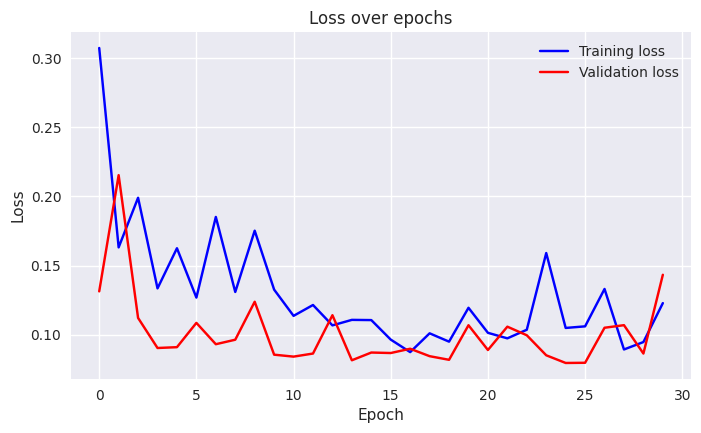

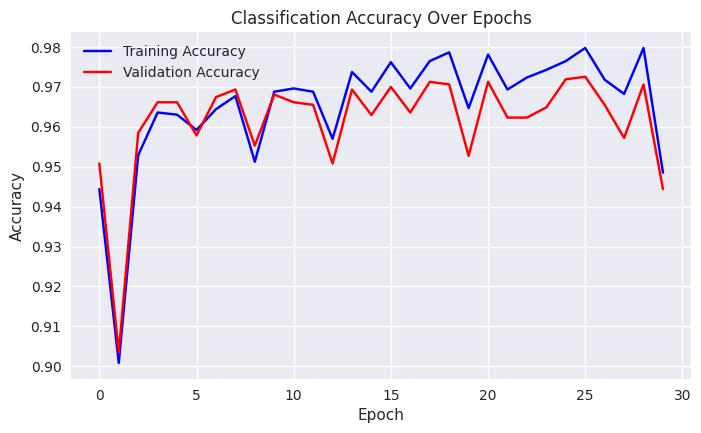

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, val_loader, N_EPOCHS, DEVICE)

#TrainingSet Result

Accuracy: 0.9485072582854013
Precision: 0.9992028696691909
Recall: 0.9309320460453027
Specificity: 0.9979123173277662
F1: 0.9638600538254518


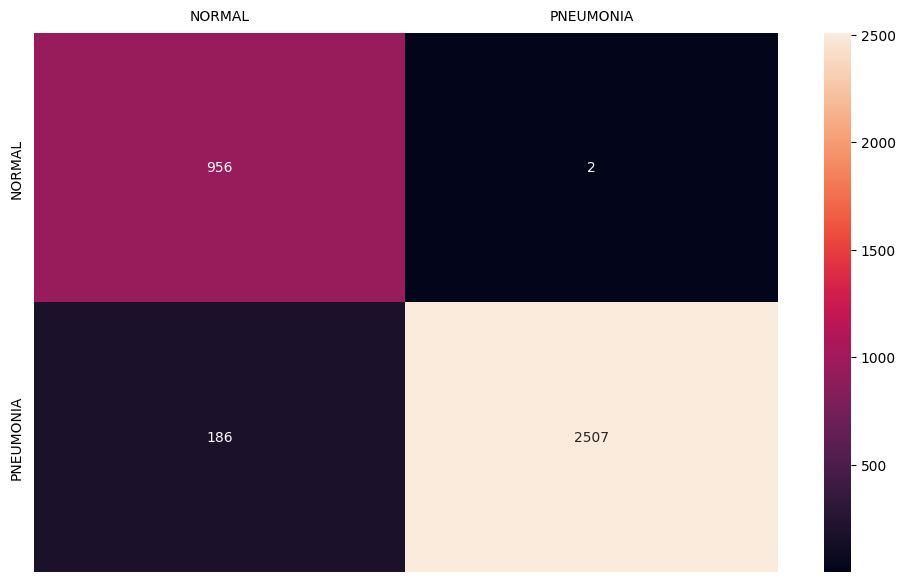

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

test_batch_size = 50

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in train_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)

    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1: {f1}")


#ValidationSet Result

Accuracy: 0.9444089456869009
Precision: 0.9936880072137061
Recall: 0.9323181049069373
Specificity: 0.9817232375979112
F1: 0.9620253164556962


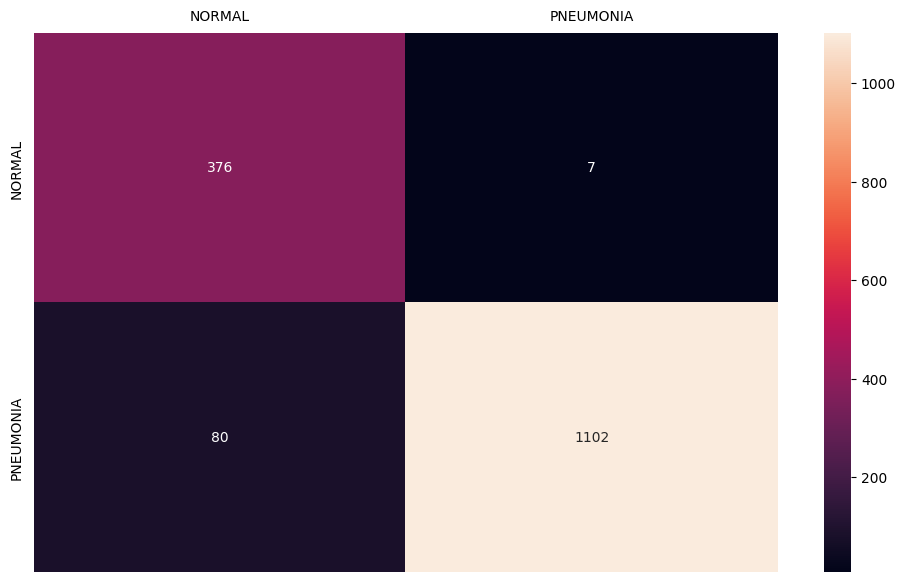

In [ ]:
test_batch_size = 50

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in val_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)

    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1: {f1}")


#TestSet Result

Accuracy: 0.9006410256410257
Precision: 0.8813953488372093
Recall: 0.9717948717948718
Specificity: 0.782051282051282
F1: 0.924390243902439


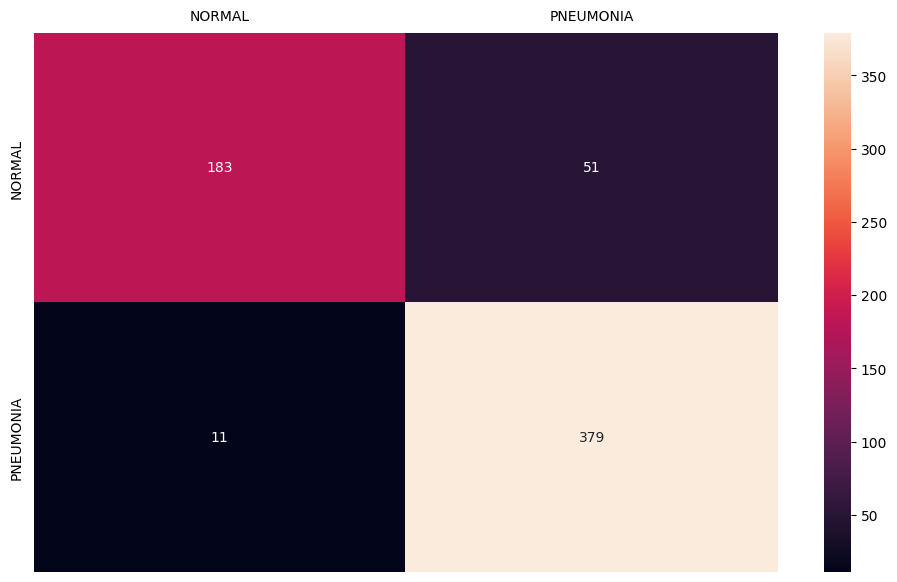

In [ ]:
test_batch_size = 50
test_dataset = ImageFolder(test_folder, transform=transformer)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)

    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1: {f1}")


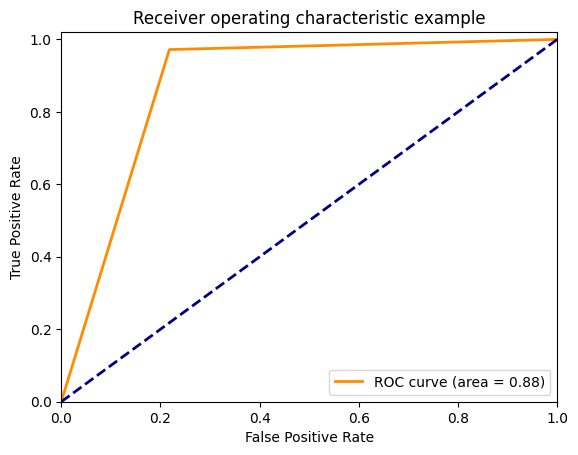

In [ ]:
# Adapted from https://discuss.pytorch.org/t/roc-curves-for-a-simple-cnn-multi-class-model/98069/2
from sklearn.metrics import roc_curve, auc, f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()